In [176]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.optimize import least_squares

In [237]:
def tuning_curve(x, loc, scale):
    return 1- 1/(1+np.exp(-(x-loc)/scale))

def tune_cells(cells, loc, scale):

    x = np.arange(len(cells))
    weights = tuning_curve(x, loc, scale).reshape(-1,1)

    # Tune the cells
    cell_means = cells.mean(axis=1).reshape(-1,1)
    tuned_cells = (cells - cell_means) * weights + cell_means

    return tuned_cells


# Fitting the mog on PCA2
def mog(x, p):
    return (
        norm.pdf(x, p[0], p[1])
        # + norm.pdf(x, p[0], [1])
    )

def residual(p, X, Y):
    return mog(X,p) - Y



In [256]:
def plot_experiment(n_times, n_cells, loc, scale, seed=2025):

    rng = np.random.default_rng(seed)
    cells = rng.uniform(
        size=(n_cells,n_times)
    )*1

    cells += rng.uniform(size=(n_cells,1))*1


    tuned_cells = tune_cells(cells, loc, scale)

    U, S, Vt = np.linalg.svd(tuned_cells, full_matrices=False)
    pca_tuned_cells = tuned_cells @ Vt.T
    pca1, pca2 = pca_tuned_cells.T[:2]


    # Plotting

    fig = plt.figure(figsize=(10,5), dpi=200)
    gs = fig.add_gridspec(2,7, width_ratios=(.5,.5,.5,.5,.01,3,3))
    fig.subplots_adjust(wspace=1, hspace=.5)

    for col in [0,1,2,3]:
        cell_ax = fig.add_subplot(gs[:,col])
        cell_ax.imshow(tuned_cells[col*100:col*100 + 100])
        cell_ax.set_xticks([])
        cell_ax.set_yticks(
            np.array([0,19,39,59,79,99]),    
            np.array([1,20,40,60,80,100])+col*100
        )

        if col==0: cell_ax.set_ylabel('Cell index')


    ax = fig.add_subplot(gs[0,5:])
    X = np.arange(n_cells)
    ax.plot(X, tuning_curve(X, loc, scale))
    ax.set_ylim(-0.1,1.1)
    ax.set_xlabel('Cell index')
    ax.set_ylabel('Tuning varability\nacross timepoints')

    ax = fig.add_subplot(gs[1,5])
    ax.scatter(pca1, pca2, s=2)
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')

    ax = fig.add_subplot(gs[1,6])
    vals, bins, _ = ax.hist(pca2, density=True, bins=40)
    bins = (bins[:-1] + bins[1:]) / 2

    res = least_squares(residual, [0,.3,0,.01], args=(bins, vals), loss='cauchy')
    ax.plot(bins, mog(bins, res.x), label='Gauss fit')
    ax.set_ylim(0, vals.max()*1.3)
    ax.legend(frameon=False, loc=(0.1,0.8))

    ax.set_xlabel('PCA2')
    ax.set_ylabel('pdf')

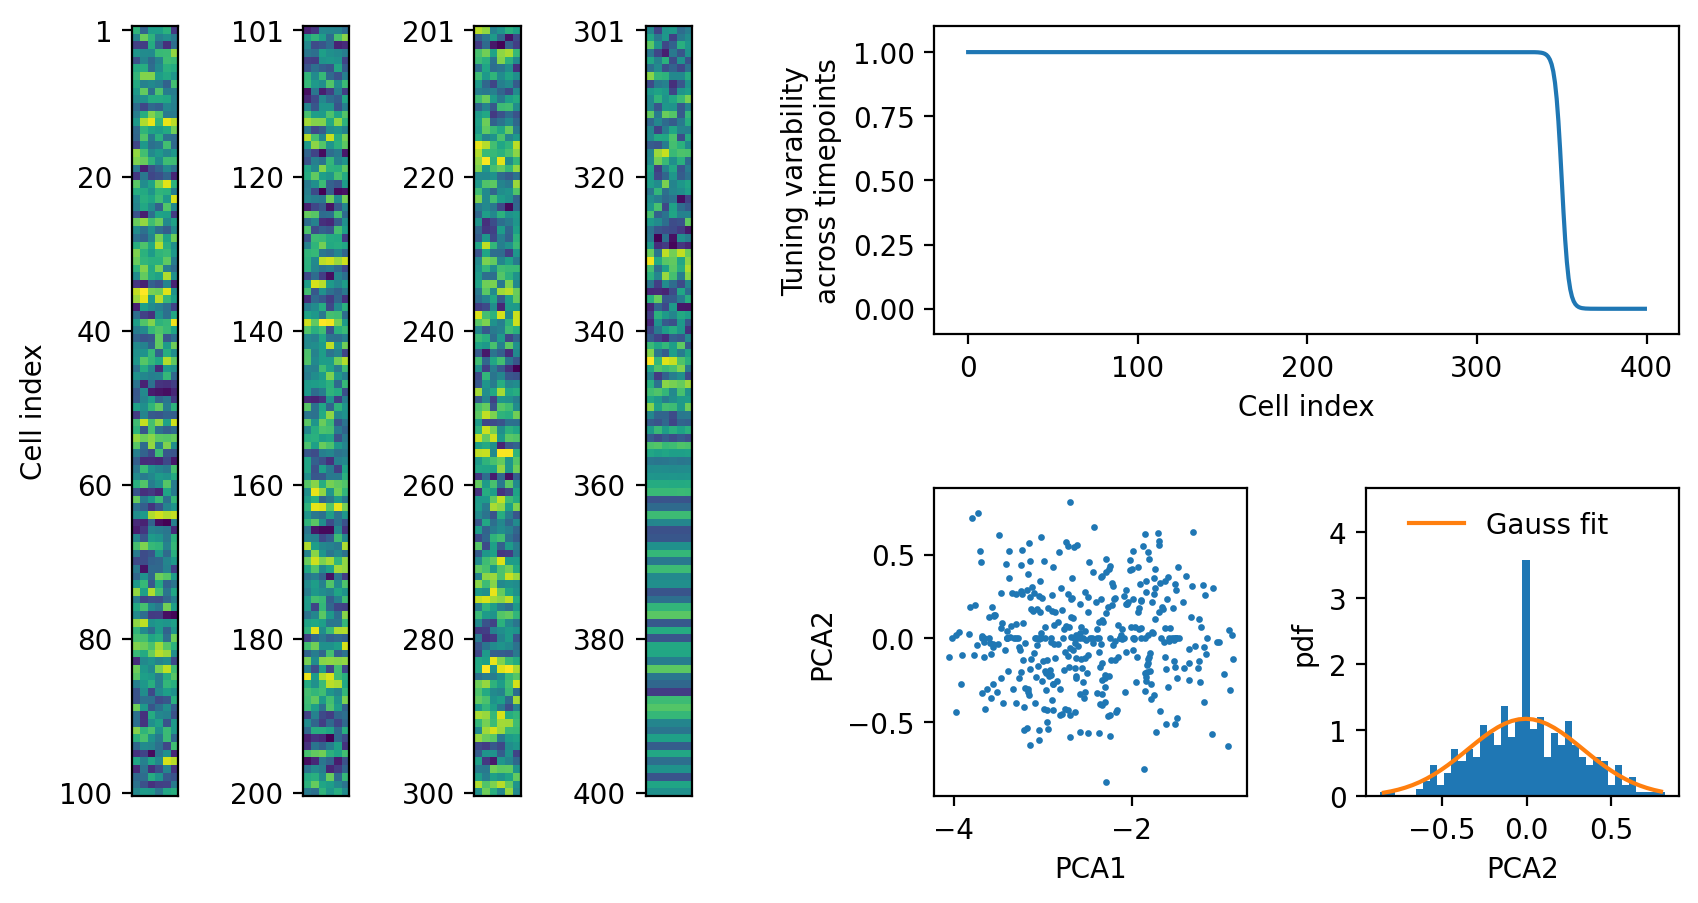

In [257]:
plot_experiment(
    n_times = 6,
    n_cells = 400,
    loc = 350,
    scale = 2,
)

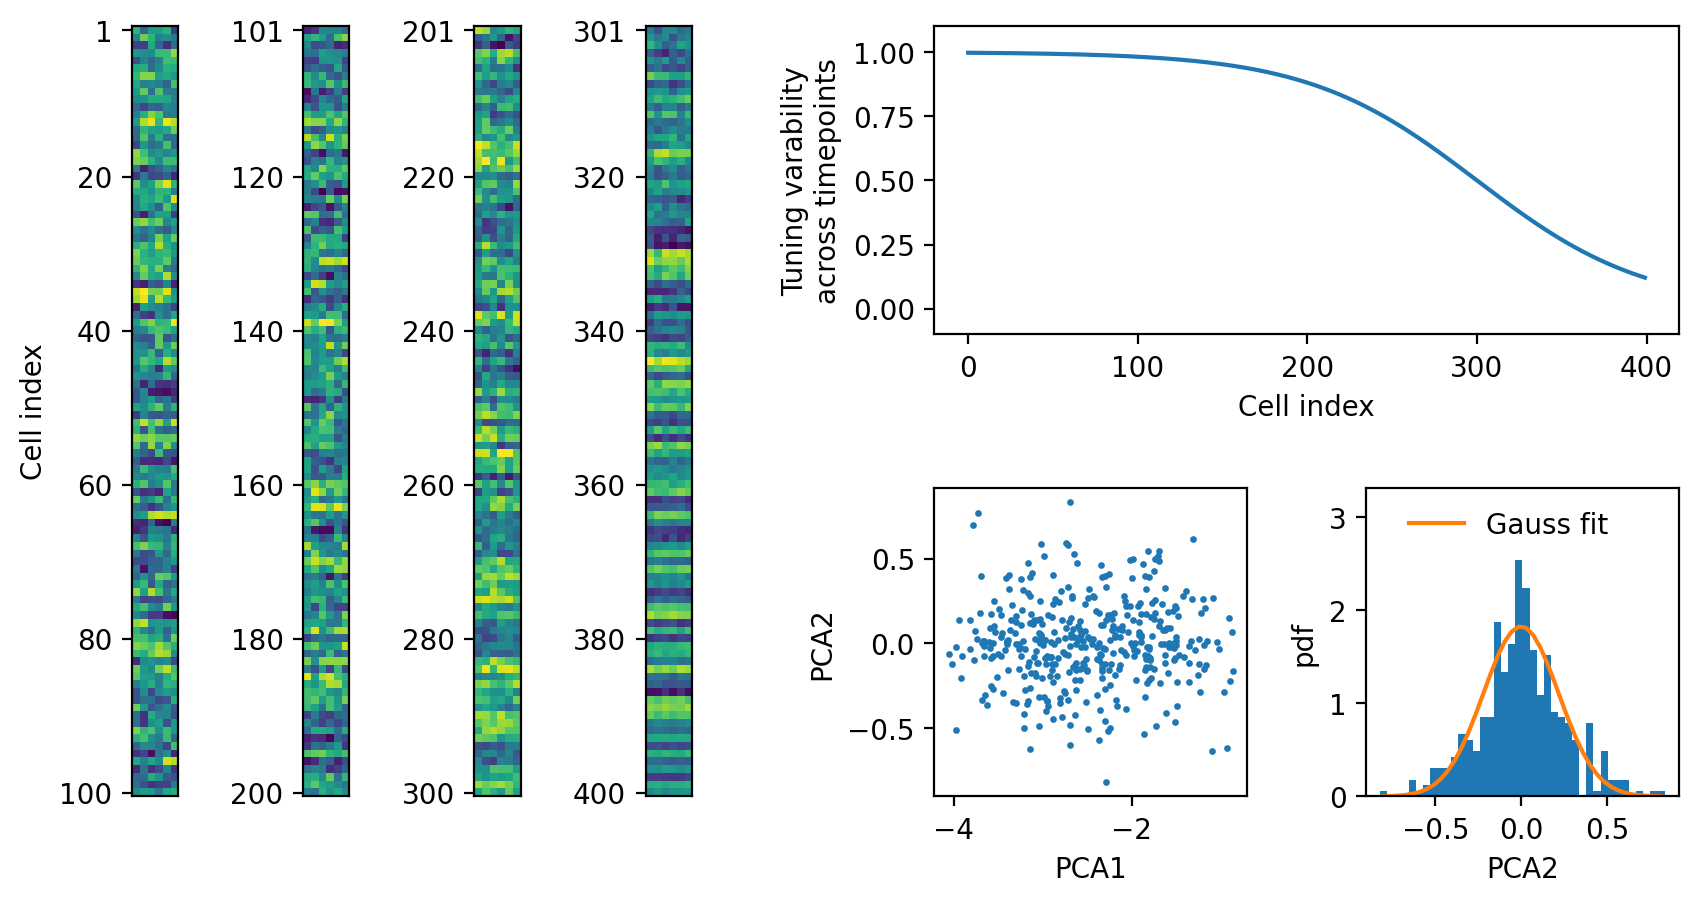

In [258]:
plot_experiment(
    n_times = 6,
    n_cells = 400,
    loc = 300,
    scale =50,
)

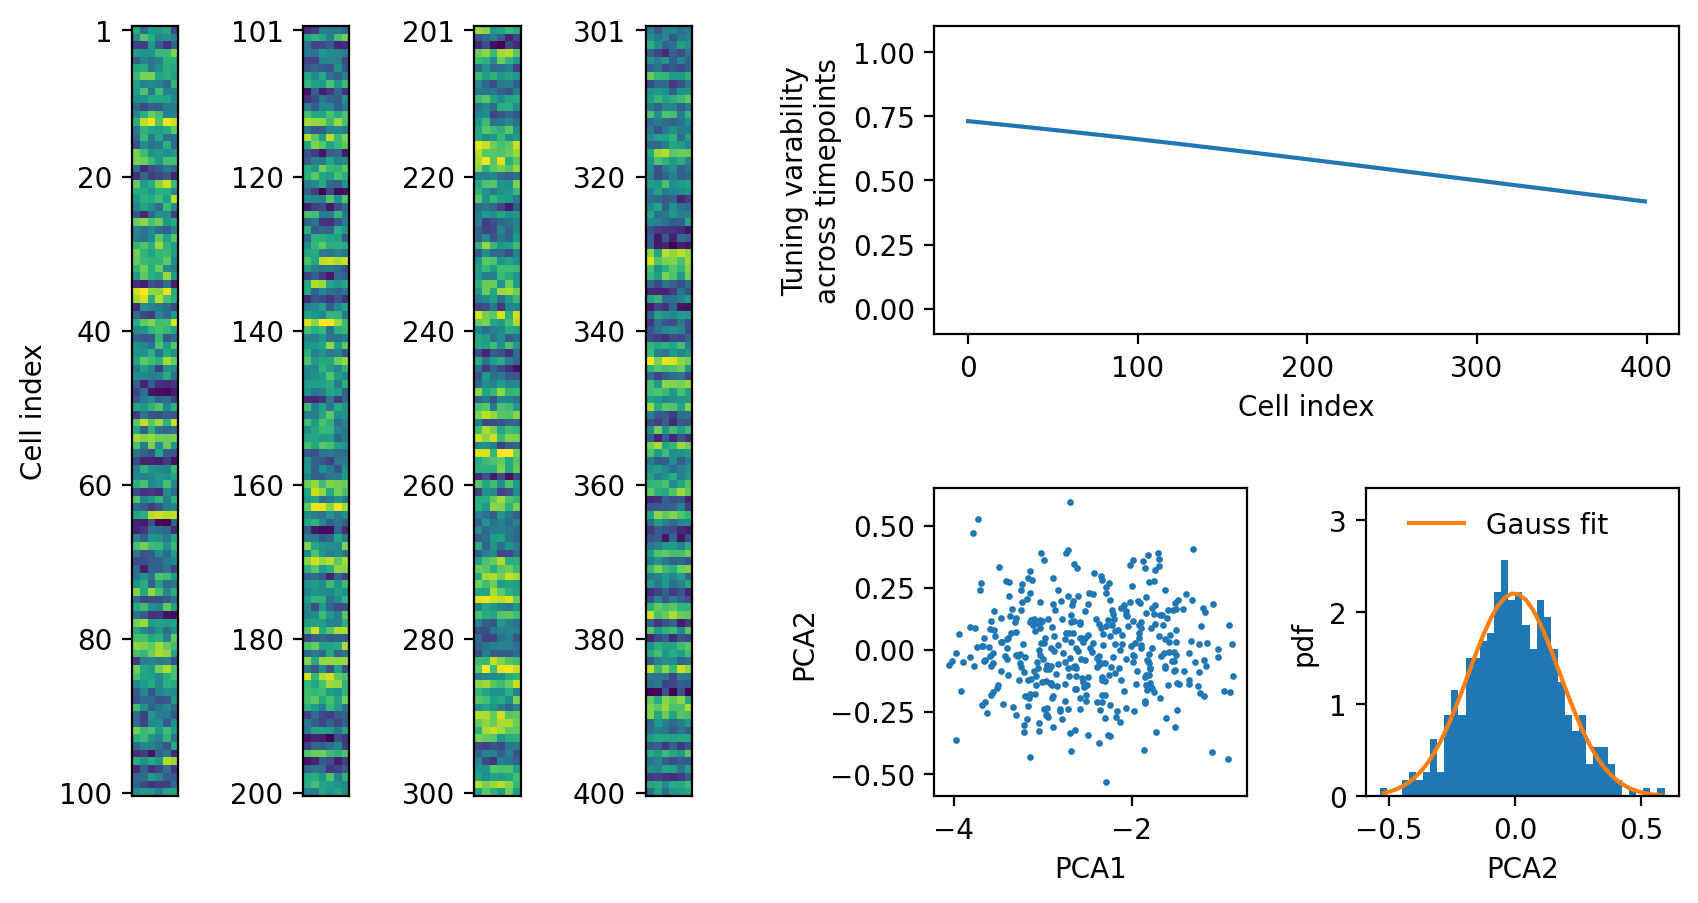

In [259]:
plot_experiment(
    n_times = 6,
    n_cells = 400,
    loc = 300,
    scale =300,
)